<font size="20">Geospatial Analysis & Visualization w/ Python</font>

# Step 0) Setup
* To get started, we need to import all the packages we'll use.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
%matplotlib notebook


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Step 1) Importing our data
* We'll load the Police Killing Data as a "DataFrame" using pandas


* Then we'll convert it into a "GeoDataFrame" using Geopandas
    * To do this, we must assign the "geometry".  In this case its point data, and the coordinates are in lat/long
    
    
* Then we need to assign a Coordiante Reference System (CRS) manually
    * ESPG is a standardized code that is used to represent CRSs.
    * 'espg:4326' is for the refers to the WGS 1984 datum, which our latitude/longitude data is based in.
        * This is a CRS that is widely used by many web-based platforms because like Google Maps and Mapbox
        * The original only had addresses, not coordinates, so we used a webservice (Mapbox) to generate the coordinates of our addresses
        
        
* Once we have the data loaded, calling .head() will give us a "preview" of our dataset

In [ ]:
# We import the Police Killings file, and set the incident ID as the index
police_Killings_Tabular = pd.read_csv('Data/PoliceKillings.csv',
                                      parse_dates=['date'],
                                      index_col=['id_incident']
                                     )

# We can then convert the pandas dataframe into a geopandas "GeodataFrame"
police_Killings = gpd.GeoDataFrame(police_Killings_Tabular,
    geometry=gpd.points_from_xy(police_Killings_Tabular.longitude,
                                police_Killings_Tabular.latitude
                               )
                                  )

# Now we can assign a CRS
WGS_1984={'init' :'epsg:4326'}
police_Killings.crs = WGS_1984

# Lets sort the incidents by date and then take a quick look.
police_Killings=police_Killings.sort_values(by='date')
police_Killings.head()

### Now we'll load some data from the 2016 Census

* We have a tabular dataset of population data.

* We'll load it using pandas

In [ ]:
# We'll import the tabualr census data with pandas
Census_Tabular = pd.read_csv('Data/Census.csv',index_col=['PRUID'])
Census_Tabular.head()

### We also have a provincial boundary shapefile

* Shapefile are used to store georphric data.  They already have projections and coordiantes associated with them.
    * Geopandas has similar functionality to pandas and we can use it to import shapefiles.  But the read_file() method had less options, so we have to set the index manually.

In [ ]:
# We'll import provincial boundaries using geopandas
Provincial_Boundaries = gpd.read_file('Data/Provincial_Boundaries.shp').set_index('PRUID')
Provincial_Boundaries.head()

# Step 2) Joining our census data

* This will let us map the disparity by province and do a more detailed analysis

* PRUID is a "unique identifier" that represents the provinces.

    * Since both have the PRUID set as the index, we don't need to specify a join key.

In [ ]:
Test_Join = Provincial_Boundaries.join(Census_Tabular)
Test_Join.head()

# But our join fails :(

* ### Notice the NaN values.

* NaN represetns missing data values
    * Lets look at the index for both files?  Maybe we have a datatype missmatch?

In [ ]:
print(Provincial_Boundaries.index.dtype)
print(Census_Tabular.index.dtype)

### Sure enough!  The Provincial_Boundaries index is an "object", not an integer.

* We can fix that easily and then do the join!
    * We just need to change the datatype of the Provincial_Boundaries layer.

### We can assign the datatype using the .astype() function.

### But datatype do we assign?
* Hint The anser is in the cell above!!

In [ ]:
dtype = 
Provincial_Boundaries.index = Provincial_Boundaries.index.astype(dtype)
Provincial_Data = Provincial_Boundaries.join(Census_Tabular)
Provincial_Data.head()

# Step 3) Exploring the data

### First lets make a quick map.

* Our Layers need to be in the same coordinate system to match up properly on a map!

* We can re-project the police_Killings layer using the .to_crs function to set the CRS to that of the Provinces
    * The provinces layer uses the Canada Lambert Conformal Conic projection (LCC).  This is the standard projection used by stats canada and is ideally suited for displaying the whole of country.
        
        
* Once both datasets are in the same coordinate system, we can make a map!


* First we must define a plot, using the matplotlib.pyplot package.  We imported this earlier as "plt"
    * We use the plt.subplots() to create a figure, and we can define how big we want it to be
    
    
* Geoapandas can then use the .plot() fucntion to create a map using matplotlib.
    * We simply tell it what axis to draw the plot on with ax="axes"
    * Then set a few other parameters:
        * We just want the provinces as a grey background so we can set the color
        * We want to classify killings by race, so we can set race as the column.  THen we can add a legend to aid interpretation of the data

In [ ]:
# We can use .to_crs() to create a police killings layer with the same projection as the provinces layer.
police_Killings = police_Killings.to_crs(Provincial_Data.crs)

# Now, we can create a figure using matplotlib (plt), first we define the figure and the size
fig,axes=plt.subplots(
    figsize=(6,6)
)

# Now we can add the provinces using the .plot() function.  We set the plotting axes and give it a grey color
cb = Provincial_Data.plot(
    ax=axes,
    column='Total',
    cmap = 'Greys',
    edgecolor='grey',
    legend=True,
)

# Then we add the police_Killings_LCC.  We'll set the column to 'race', so we can disply by race,
# give the point markers a few more parameters, and add them to a legend
police_Killings.plot(
    ax=axes,
    column='race',
    edgecolor='k',
    markersize=15,
    legend=True,
    legend_kwds={'loc': 'upper right','fontsize':8}
)

### And now you've made your first map with python!

* But its an ugly map :(
    * It doesn't look great.  This is just the quick and dirty way to look ata data
    * To make things more presentable, we'll have to be more explicit in setting up our map.  But that's a task for later.


### For now, lets move on and look at the dataset in more detail.

* Pandas & Geopandas have some nice features to quickly summarize our dataset.



* We can use .count() to get the total # incidents.
    * Callling .count() as is, will give us a list of all the columns, and a count for each.  We can see most collumns are "full" but in the "geocoding_Notes" column, we can see that 4 points don't have coordinates associated with their address.  This suggests there was an error in the data entry process.  We don't need to worry about this though.    

In [ ]:
police_Killings.count()

* We can use .mean(), .min(), etc. followed by ['age'] to get some vital statistics on the age of victims.

* We can use .describe() to summarize multiple attributes of the age column.

In [ ]:
print('Age Distribution of Victims')
print()
print('Mean:                ',
      police_Killings.mean()['age']
     )
print()
print('Standard Deviation:  ',
      police_Killings.std()['age']
     )
print()
print('Youngest:            ',
      police_Killings.max()['age']
     )
print()
print('Oldest:              ',
      police_Killings.min()['age']
     )

police_Killings.describe()['age']

### We can resample our data to look for trends
* The date column is a special type of data that allows us to resample our data by year, month, etc
* The dataset has to be in order by date for this to work (we did this alread).

In [ ]:
Resampled = police_Killings.set_index('date').resample('Y').count()

## scipy can be used to calculate a linear regression line and print the results
Regression_Line = stats.linregress(Resampled.index.year,Resampled['id_victim'])
print(Regression_Line)

plt.figure(figsize=(6,6))

## We can make a scatter plot of the annual killings
plt.scatter(
    Resampled.index.year,
    Resampled['id_victim'],
    color='black',
    label='Yearly Total'
)

## Then plot he increasing trendline over it and add the slope and pvalue to the legend.
plt.plot(
    Resampled.index.year,
    Resampled.index.year*Regression_Line[0]+Regression_Line[1],
    label='Trend Line: '+str(np.round(Regression_Line[0],3))+'\np-value: '+str(np.round(Regression_Line[3],3)),
    color='red'
    )

plt.legend()
plt.title('Police Killings per Year in Canda')

### We can group our data to look for patterns too.

* the .groupby() function can accept one or multple paramters to group our dataset by.
    * This allows us to create complex queries if we want.
* We can have to follow up with .count(), .mean(), etc.
    * This tells us "how" to aggregate

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))

## This is a dictionary to set colors based on specific values.  We're using Hex color codes here.
## They're a common way for specifiying colors
Pie_Colors = {'None':'#FF0000',
              'Knife':'#fecc5c',
              'Firearm':'#ffffb2',
              'Other weapons':'#fd8d3c'}

## Group by the variable we want, summarize by count, then make our pie chart!
Armed = police_Killings.groupby(['armed_type']).count()
ax.pie(
    Armed['id_victim'],
    labels=Armed.index,
    textprops={'fontsize': 8},
    colors=[Pie_Colors[i] for i in Armed.index],
    autopct='%1.1f%%',
    wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'}
)
ax.set_title('Police Killings: Was the Victim Armed?')
plt.tight_layout()

### Groupby allows us to create very complex queries if we want

* We can search combinations of two or more variables

* This retruns a record with two indexes: Department and armed type

In [ ]:
Group = police_Killings.groupby(['Department','armed_type']).count()['id_victim']#.sort_values(ascending=True)

print(Group)

### What police departments kill the most unarmed people?

* We can use the .loc command to do a search for all departments with more than one unarmed killing.

* Then we sort the record, select the top 5, and plot them.

In [ ]:
## The unstack command allows us to turn the last index into our colum names
Force=Group.unstack()
Force['Total'] = Force.sum(axis=1)
Force['Unarmed_Frac']=Force['None']/Force['Total']

## .loc is the search function.
## .sort_values() sorts our records in ascending order.
## [-5:] grabs just the last five records
Force = Force.loc[Force['None']>1].sort_values(by='None')[-5:]
print(Force)

Force_Labels={'Toronto Police Service':'Toronto',
              'RCMP':'RCMP',
              'Vancouver Police Department':'Vancouver',
              'Service de police de la Ville de Montreal':'Montreal',
              'Edmonton Police Service':'Edmonton'}

fig,ax=plt.subplots(figsize=(6,5))

ax.barh(Force.index,Force['None'],facecolor='#FF0000',edgecolor='black')
ax.set_yticklabels([Force_Labels[f] for f in Force.index.values])
ax.set_title('Unarmed Victims by Deparment (2000-2015)')

### We're intersted in a specific question.  What's the distribution of police killings by race?


In [ ]:
police_Killings.groupby(['race']).count()['date'].sort_values()

# Step 4) Normalizing our Data

* The racial demographics of Canada aren't evenly split however!

* We need to Normalize our data by population statistics.

* Lets look at our census data again


In [ ]:
Provincial_Data[Census_Tabular.columns]

### The first row contains the total values for the whole country.  We can use this to calculate a police killing rate.

* But the Canadian Census' racial categories don't match up perfectly with the police violence dataset's racial
* How can we work around this?
    * We have the largest three groups in the police killing set: White, Indigenous, and Black.  So we can work with them as is
    * The other races make up a small portion of total killings.  And we can't be entirely sure how the CBC defined their groupings.  So, lets add a new category: "Other Minorities"
    
* We'll do this for both the provincial boundaires and the police_Killings
    * For the police killings, we'll leave the unknow records alone

In [ ]:
Other_Minorities=['South Asian', 'Chinese', 'Filipino','Latin American',
 'Arab', 'Southeast Asian', 'West Asian', 'Korean',
'Japansese', 'Visible minority, n.i.e', 'Mixed']
Provincial_Data['Other Minorities']=Provincial_Data[Other_Minorities].sum(axis=1)

Other_Minorities=['Latin American', 'Arab', 'Other', 'South Asian', 'Asian']
police_Killings['race'] = police_Killings['race'].replace(to_replace=Other_Minorities,value='Other Minorities')


# From here, we can calculate the Police Killing Rate (PKR).

* Dividing the total number of killings by the population gives us ...

In [ ]:
Races = ['Indigenous','Black','Caucasian','Other Minorities']
Race_Breakdown = police_Killings.groupby(['race']).count()['id_victim']
Can_Pop = Provincial_Data[Races].sum()

Racial_Rates = Race_Breakdown.T[Races]/Can_Pop
Racial_Rates['CA. Average']=Race_Breakdown.T[Races].sum()/Can_Pop.sum()
print(Racial_Rates)
# police_Killings.groupby(['race']).count()['date'].sort_values()

### This number isn't that meaningful though.  It represents the number of killings "per person" over the whole study period.

* Lets convert the rate to a more meaninful unit.  Killings / Million Residents / Year

* The date record is a "date" object.
* It has some added functionality like being able to query the the year, month, day

In [ ]:
First_Year = police_Killings['date'].min().year
Last_Year = police_Killings['date'].max().year
print(First_Year,Last_Year)

### How might we calculate our police killing rate?

* What should we set as scale and duration to convert units?

In [ ]:
Scale =
Duration = 
rate_Conversion = Scale / Duration

Racial_Rates=Racial_Rates.sort_values(ascending=True)

fig, ax = plt.subplots(figsize = (5,5))
ax.barh(
    Racial_Rates.index,
    Racial_Rates.values * rate_Conversion,
    facecolor='#FF0000',
    edgecolor='black',
    linewidth=1
)
ax.set_title('Police Killings Rates by Race in Canada')
ax.set_xlabel('Killings per Year per Million People')
plt.tight_layout()

# The Police killing rates are 5x higher for Indigenous people and 4x higher for Black people than it is fo White people.

* ## This is an abhorent example of systemic racism in Canadian Policing.


# Lets look at the PKR by province.
Now we  want to normalize by provincial demographics.

* We have a few more steps to go through first.
    * The police killings and census data use different abbreviations.  To do a join our dataset with the census data we'll need to assign an new abbreviaton
    * We'll us a dictionary to do this
    
    
* Then we can summarize the killings by province and join it to the Provinces_Join layer

* Now we can summarize the killings by province and join it to the Provinces_Join layer


* Note Prince Edward Island doesn't have any.

In [ ]:
race_by_Province = police_Killings.groupby(['prov','race']).count()
race_by_Province = race_by_Province['date'].unstack()
race_by_Province['Total'] = race_by_Province.sum(axis=1)

for col in Races:
    Provincial_Data = Provincial_Data.join(race_by_Province[col],on='prov',rsuffix='_Killings')

for col in ['Unknown','Total']:
    Provincial_Data = Provincial_Data.join(race_by_Province[col],on='prov',rsuffix='_Killings')
Provincial_Data

# Some provines/groups don't have any records.  Those are given NaN values, and need to be repalced with zeros
Provincial_Data[[x+'_Killings' for x in Races]]=Provincial_Data[[x+'_Killings' for x in Races]].fillna(0)
Provincial_Data['Total_Killings']=Provincial_Data['Total_Killings'].fillna(0)
Provincial_Data[['Unknown' for x in Races]].fillna(0)

Provincial_Data.head()

# Step 5) Calcualte and map the Police Killing Rate (PKR) on the provincial level
* Nunavut has a huge problem.  Its not a conicidence that the population is 75% Inuit.

In [ ]:
Provincial_Data['PKR']=(Provincial_Data['Total_Killings']/Provincial_Data['Total']*rate_Conversion)

print(Provincial_Data[['prov','PKR']].sort_values(by='PKR'))

### We can make a chloropleth map of this pattern.

* Lets check out colorbrewer for help picking a good color scheme

https://colorbrewer2.org/

In [ ]:
## We can define our own class break values, labels, and colors for the map
bins = [-0.01,0.5,1,1.4,4,9]
labels = ['<0.5','0.5 - 1','1 - 1.3','3.1','7.7']
colors = ['#fee5d9','#fcae91','#fb6a4a','#de2d26','#FF0000']

## We can use the labels and colors to create a color dictionary
PKR_Color = {key:value for key,value in zip(labels,colors)}

## The pd.cut() command will creat a new record for us containg class labels.
Provincial_Data['PKR_Classes']=(pd.cut(Provincial_Data['PKR'],bins=bins,labels=labels)).astype('str')


fig,ax=plt.subplots(figsize=(6,6))

## To make a better map with geopandas, we have to loop through recrods and plot each class seprately
## Then create a custom legend item for it.

Patches=[]
for pkr_class in Provincial_Data['PKR_Classes'].unique():
    ## kwargs allows us to set multiple arguments for the plot and save them
    ## We can then used them in multiple commands
    kwargs = {'facecolor':PKR_Color[pkr_class],
             'edgecolor':'k',
             'label':pkr_class}
    
    Provincial_Data.loc[Provincial_Data['PKR_Classes']==pkr_class].plot(
        ax=ax,
        **kwargs
             )
    
    ## mpatches.Patch() allows us to create a custom legend item for each class
    Patches.append(mpatches.Patch(**kwargs))
    
## We add the legend items to the legend
ax.legend(handles=Patches) 

## This turns off the numeric x,y labels
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title('Police Killings per Year per Million People')

# Step 6) Calculate a Police Killings Discrimination Index (PKDI):

* For this, we'll compare the PKR for white people to the combined PKR of black and indigenous people

* We'll use the following equations:


\begin{align}
\ PKR_{W} & = (\frac{White Killings}{White Population}) * 1e6 / 18\\
\end{align}

\begin{align}
\ PKR_{BI} & = (\frac{Black Killings + Indigenous Killings}{Black Population + Indigenous Population}) * 1e6 / 18
\end{align}

\begin{align}
\ PKDI & = PKR_{BI} - PKR_{W}\\
\end{align}

## This will hightlight the disparities in police killings
* We'll classify the data using the following scheme:
    
        * "Low Bias": -0.5 to 0.5 - This is the rate killings of whites.  Within these ranges, differences might be due to presence or lacktherof of a certain groups 
        * "Moderate Bias": 0.5 to 1 - Greater than the white rate, less than the national average
        * "Severe Bias": 1 to 3 - Greater than the national rate, less than the indigenouos rate
        * "Extreme Bias: 3 to 10 - Greater than the national indigenous rate
    

In [ ]:
Provincial_Data['PKR_W']=Provincial_Data['Caucasian_Killings']/Provincial_Data['Caucasian']*rate_Conversion
Provincial_Data['PKR_BI']=(Provincial_Data['Indigenous_Killings']+Provincial_Data['Black_Killings'])/(Provincial_Data['Indigenous']+Provincial_Data['Black'])*rate_Conversion

Provincial_Data['PKDI'] = Provincial_Data['PKR_BI'] - Provincial_Data['PKR_W']

Provincial_Data['PKDI']=Provincial_Data['PKDI'].fillna(0)


bins = [-0.5,0.5,1,2,10.0]
labels = ['Low Bias','Moderate Bias','Severe Bias','Extreme Bias']
Provincial_Data['PKDI_Classes']=(pd.cut(Provincial_Data['PKDI'],bins=bins,labels=labels)).astype('str')

Provincial_Data.round(2)

# print(Provincial_Data[['prov','PKDI','PKDI_Classes']].sort_values(by='PKDI').round(2))

### Lets map the patterns

In [ ]:
fig,ax1=plt.subplots(figsize=(5,5))
colors = ['#ffffb2','#fecc5c','#fd8d3c','#FF0000']
PKDI_Color = {key:value for key,value in zip(labels,colors)}

Patches = []
for pkdi_class in Provincial_Data['PKDI_Classes'].unique():
    kwargs = {'facecolor':PKDI_Color[pkdi_class],
             'edgecolor':'black',
              'linewidth':.5,
             'label':pkdi_class}
    Provincial_Data.loc[Provincial_Data['PKDI_Classes']==pkdi_class].plot(
        ax=ax1,
        **kwargs
             )
    Patches.append(mpatches.Patch(**kwargs))
    
ax1.legend(handles=Patches,) 
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title('Police Killing Discrimination Index')

# Step 7) Save the data so we can use it in the future
* We're going to save it as a shapefile for use with geopandas or a desktop GIS
* We're also going to save it as a "GeoJSON" file.  This datatype is well suited for webmapping.  Which I cover in a dfferent workshp!

In [ ]:
Provincial_Data.to_file('Data/Provincial_Police_Violence.shp')

# Step 8) Putting Everything Together: Create an Infographic

* Matplotlib alows us to be very specific in determining our layout with gridspec.


* We can create a large plot and define specifically what we want.


* We'll have two maps, showing the PKR and the PKDI on the left


* Then we'll add some smaller plots on the right showing the annual trend, national PKR by race, and some pie charts


* We can set our default ontsize for consistency

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(100,100)

PKR_Map = fig.add_subplot(gs[0:45 , 0:45])
PKDI_Map = fig.add_subplot(gs[0:45, 55:])



Annual_Trend = fig.add_subplot(gs[47:65, 5:45])
PKR_national = fig.add_subplot(gs[47:65, 65:])

Armed_Stats = fig.add_subplot(gs[74:92, 5:45])
Dept_Stats = fig.add_subplot(gs[74:92, 65:])


SourceStatement = fig.add_subplot(gs[93:,:])

plt.subplots_adjust(left=.05, bottom=.05, right=.95, top=.95, wspace=.1, hspace=.1)

fig.patch.set_facecolor([.9,.9,.9])
plt.suptitle('Police Killings in Canada (2000-2017)')


### Now we can add things to the figure
* First lets do the maps

In [ ]:
## Plot the PKR
Patches=[]
for pkr_class in Provincial_Data['PKR_Classes'].unique():
    kwargs = {'facecolor':PKR_Color[pkr_class],
             'edgecolor':'k',
             'label':pkr_class}
    Provincial_Data.loc[Provincial_Data['PKR_Classes']==pkr_class].plot(
        ax=PKR_Map,
        **kwargs
             )
    Patches.append(mpatches.Patch(**kwargs))
PKR_Map.legend(handles=Patches) 
PKR_Map.get_xaxis().set_visible(False)
PKR_Map.get_yaxis().set_visible(False)
PKR_Map.set_title('Police Killings per Year per Million People')

# Plot the PKDI
Patches = []
for pkdi_class in Provincial_Data['PKDI_Classes'].unique():
    kwargs = {'facecolor':PKDI_Color[pkdi_class],
             'edgecolor':'k',
             'label':pkdi_class}
    Provincial_Data.loc[Provincial_Data['PKDI_Classes']==pkdi_class].plot(
        ax=PKDI_Map,
        **kwargs
             )
    Patches.append(mpatches.Patch(**kwargs))
PKDI_Map.legend(handles=Patches,) 
PKDI_Map.get_xaxis().set_visible(False)
PKDI_Map.get_yaxis().set_visible(False)
PKDI_Map.set_title('Police Killing Racial Discrimination Index')

## Plot the annual trend
Annual_Trend.plot(
    Resampled.index.year,
    Resampled['id_victim'],
    color='black',
)
Annual_Trend.plot(
    Resampled.index.year,
    Resampled.index.year*Regression_Line[0]+Regression_Line[1],
    label='Trend Line: '+str(np.round(Regression_Line[0],3))+'\np-value: '+str(np.round(Regression_Line[3],3)),
    color='red'
    )
Annual_Trend.legend()
Annual_Trend.set_title('Annual Trend')
Annual_Trend.set_xticks([2000,2005,2010,2015])

## Plot the Average PKR
PKR_national.barh(
    Racial_Rates.index,
    Racial_Rates.values * rate_Conversion,
    facecolor='#FF0000',
    edgecolor='black',
    linewidth=1
)
PKR_national.set_title('Racial Disparity: National Average')
PKR_national.set_xlabel('Killings per Year per million residents')

## plot the weapon type
Armed_Stats.pie(
    Armed['id_victim'],
    labels=Armed.index,
    colors=[Pie_Colors[i] for i in Armed.index],
    textprops={'fontsize': 8},
    autopct='%1.1f%%',
    wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'}
)
Armed_Stats.set_title('Was the Victim Armed?')

## Plot the breakdown by department
Dept_Stats.barh(Force.index,Force['None'],facecolor='#FF0000',edgecolor='black')
Dept_Stats.set_yticklabels([Force_Labels[f] for f in Force.index.values])
Dept_Stats.set_title('Unarmed Victims by Deparment')

## Add a source statement
Descriptor = \
'''Infographic Created by June Skeeter. Data Soruces: The CBC "Deadly Force (2018)" & Stats Canada

The Police Killing Discrimination Index (PKDI) quantifies the disparitiy in police killing rates (PKR) between Black and Idigenous people and White people in Canada.
The PKDI is deined as: PKDI = PKR$_{Black+Indigenous}$-PKR$_{White}$'''

# Descriptor = 'Kitties'
SourceStatement.set_axis_off()
SourceStatement.text(0, 0, 
                     Descriptor,
                     horizontalalignment='left',
                     verticalalignment='center',
                    )

plt.savefig('InfoGraphic.png',facecolor=fig.get_facecolor(),edgeolor='k')

# Updated Data for BC

2013 - May 2021

In [2]:
# the .read_file() function reads shapefiles
MVan_CT = gpd.read_file('Data/CensusTracts/SimplyAnalytics_Shapefiles_2021-06-01_17_44_45_9e5629a2de473cd5362919f9edc33853.shp')
print(MVan_CT.crs)
MVan_CT = MVan_CT.rename(columns={
'VALUE0': 'Aboriginal identity, 2016',
'VALUE1': 'Population, 2016',
'VALUE2': 'Total visible minority population, 2016'
                    })

MVan_CT['NonWhitePCT'] = MVan_CT[['Aboriginal identity, 2016',
'Total visible minority population, 2016']].sum(axis=1)/MVan_CT['Population, 2016']*100

# .to_crs()changes the coordinate system
# Provincial_Data = Provincial_Data.to_crs('EPSG:4326')
# .to_file() saves our data to the specified format
print('Data Converted')
print(MVan_CT.NonWhitePCT.describe())
MVan_CT.to_file("Data/MVan_CT.json", driver = "GeoJSON")
MVan_CT.head()

epsg:4326
Data Converted
count    474.000000
mean      50.244791
std       23.706768
min        4.712042
25%       28.461442
50%       49.974349
75%       70.736891
max      100.000000
Name: NonWhitePCT, dtype: float64


,spatial_id,name,"Aboriginal identity, 2016","Population, 2016","Total visible minority population, 2016",geometry,NonWhitePCT
0,9330001.01,"CT0001.01, Vancouver, BC",175.0,6293.0,3129.0,"POLYGON ((-123.02367 49.21204, -123.02371 49.2...",52.502781
1,9330001.02,"CT0001.02, Vancouver, BC",74.0,5456.0,3633.0,"POLYGON ((-123.02768 49.21005, -123.02807 49.2...",67.943548
2,9330002.01,"CT0002.01, Vancouver, BC",95.0,6150.0,4027.0,"POLYGON ((-123.04137 49.21830, -123.04138 49.2...",67.024390
3,9330002.03,"CT0002.03, Vancouver, BC",65.0,4077.0,3547.0,"POLYGON ((-123.05938 49.21195, -123.05917 49.2...",88.594555
4,9330002.04,"CT0002.04, Vancouver, BC",44.0,4509.0,2764.0,"POLYGON ((-123.05970 49.21147, -123.05917 49.2...",62.275449


In [4]:
# We import the Police Killings file, and set the incident ID as the index
BC_Tabular = pd.read_csv('Data/BC_Geocoded.csv',
                                      parse_dates=['date'],
                                      index_col=['id_incident']
                                     )

# We can then convert the pandas dataframe into a geopandas "GeodataFrame"
BC_Data = gpd.GeoDataFrame(BC_Tabular,
    geometry=gpd.points_from_xy(BC_Tabular.longitude,
                                BC_Tabular.latitude
                               )
                                  )

# Now we can assign a CRS
WGS_1984={'init' :'epsg:4326'}
BC_Data.crs = WGS_1984

# Lets sort the incidents by date and then take a quick look.
BC_Data=BC_Data.sort_values(by='date')
BC_Data.head()

C:\Users\User\.conda\envs\geo-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,id_victim,date,date.1,first_name,last_name,middle_name,alias_nickname,age,gender,race,...,charge_type,charges,officers involved,Check,Inquest date,extra_source,latitude,longitude,geocoding_Notes,geometry
id_incident,,,,,,,,,,,,,,,,,,,,,
22.0,0022-V1,2013-01-31,2013-01-31,Ryan,Jacob,Allen Walter,NaN,45.0,Male,Indigenous,...,None,No,0022-P1,No,NaN,NaN,49.280632,-122.985325,NaN,POINT (-122.98532 49.28063)
NaN,105_GS,2013-02-07,2013-02-07,Gerald,Cayer,Cayer,NaN,49.0,Male,Unspecified,...,NaN,NaN,NaN,Validated,2014.03.10,https://www2.gov.bc.ca/assets/gov/birth-adopti...,49.880218,-119.452413,NaN,POINT (-119.45241 49.88022)
NaN,106_GS,2013-04-22,2013-04-22,Jeremy,Richardson,Richardson,NaN,34.0,Male,Unspecified,...,NaN,NaN,NaN,Validated,2014.03.03,https://www2.gov.bc.ca/assets/gov/birth-adopti...,48.790341,-123.713137,NaN,POINT (-123.71314 48.79034)
NaN,107_GS,2013-05-03,2013-05-03,Jesse,Lahn,Lahn,NaN,33.0,Male,Unspecified,...,NaN,NaN,NaN,Validated,2015.04.13,https://www2.gov.bc.ca/assets/gov/birth-adopti...,49.263265,-121.822080,NaN,POINT (-121.82208 49.26326)
NaN,1058_CRAP,2013-06-15,2013-06-15,Darcy,Cole,David,NaN,29.0,Male,Unspecified,...,NaN,NaN,NaN,Validated,NaN,https://www.timescolonist.com/news/local/victo...,48.452606,-123.366725,NaN,POINT (-123.36673 48.45261)


In [10]:
MVan_CT['Incidents'] = 0
for i,row in MVan_CT.iterrows():
    pip = BC_Data.within(row['geometry'])
    if pip.sum()>0:
#         print(pip.sum())
        MVan_CT.loc[MVan_CT.index==i,'Incidents']+=pip.sum()
print(MVan_CT['Incidents'].describe())

count    478.000000
mean       0.083682
std        0.350659
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: Incidents, dtype: float64


<IPython.core.display.Javascript object>


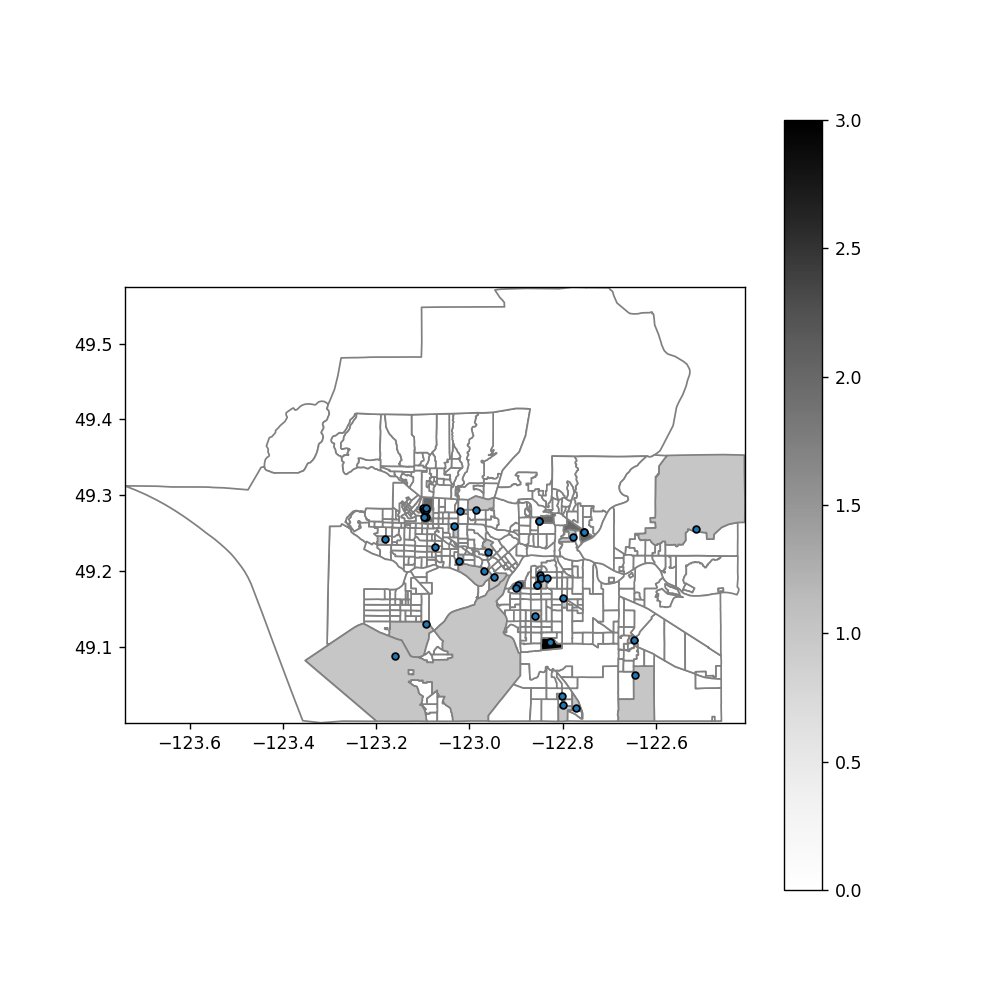

(-123.7383775267899, -122.40863989920058)

In [26]:

# Now, we can create a figure using matplotlib (plt), first we define the figure and the size
fig,axes=plt.subplots(
    figsize=(8,8)
)

# Now we can add the provinces using the .plot() function.  We set the plotting axes and give it a grey color
cb = MVan_CT.plot(
    ax=axes,
    column='Incidents',
    cmap = 'Greys',
    edgecolor='grey',
    legend=True,
)

# Then we add the police_Killings_LCC.  We'll set the column to 'race', so we can disply by race,
# give the point markers a few more parameters, and add them to a legend
BC_Data.plot(
    ax=axes,
    edgecolor='k',
    markersize=15,
    legend_kwds={'loc': 'upper right','fontsize':8}
)
X_bounds = [MVan_CT.bounds.minx.min(),MVan_CT.bounds.maxx.max()]
Y_bounds = [MVan_CT.bounds.miny.min(),MVan_CT.bounds.maxy.max()]
axes.set_ylim(Y_bounds)
axes.set_xlim(X_bounds)

<IPython.core.display.Javascript object>


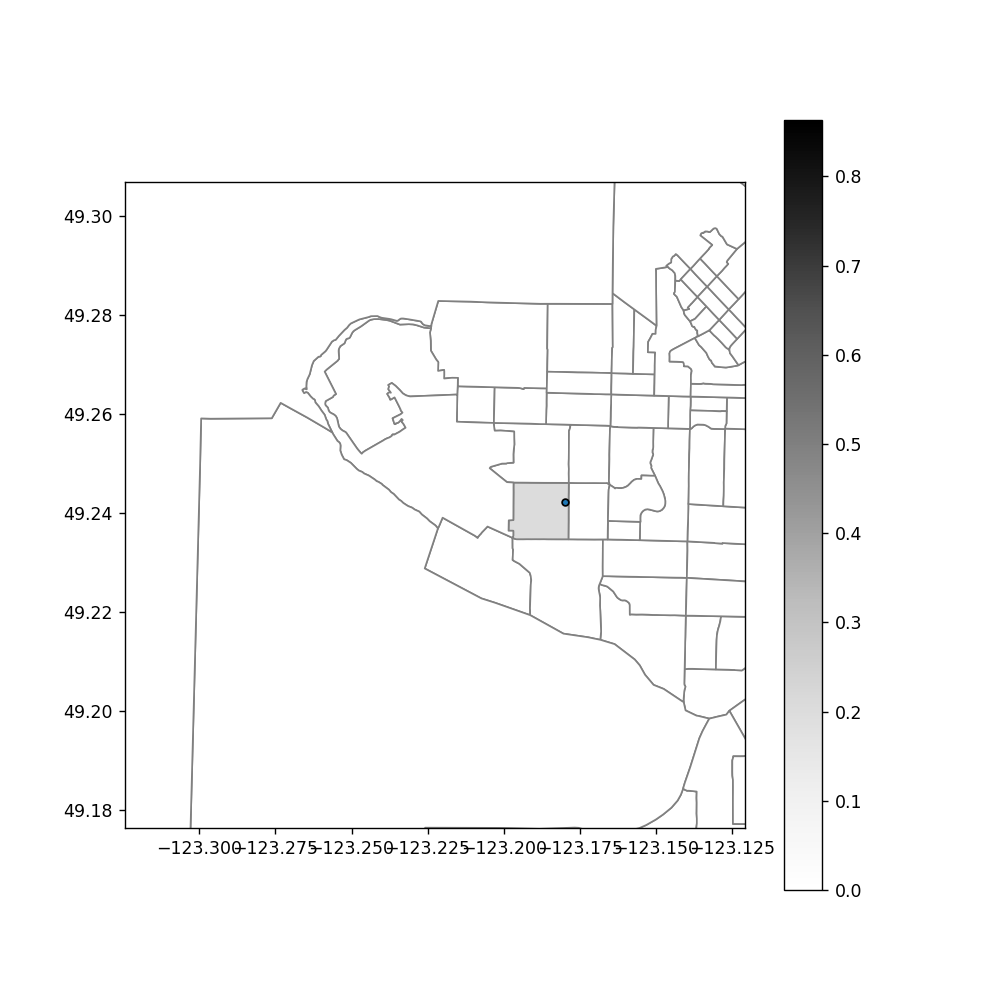

(-123.7383775267899, -122.40863989920058)

In [27]:
MVan_CT['Rate'] = MVan_CT['Incidents']/MVan_CT['Population, 2016']*1e4/8.5
# Now, we can create a figure using matplotlib (plt), first we define the figure and the size
fig,axes=plt.subplots(
    figsize=(8,8)
)

# Now we can add the provinces using the .plot() function.  We set the plotting axes and give it a grey color
cb = MVan_CT.plot(
    ax=axes,
    column='Rate',
    cmap = 'Greys',
    edgecolor='grey',
    legend=True,
)

# Then we add the police_Killings_LCC.  We'll set the column to 'race', so we can disply by race,
# give the point markers a few more parameters, and add them to a legend
BC_Data.plot(
    ax=axes,
    edgecolor='k',
    markersize=15,
    legend_kwds={'loc': 'upper right','fontsize':8}
)
X_bounds = [MVan_CT.bounds.minx.min(),MVan_CT.bounds.maxx.max()]
Y_bounds = [MVan_CT.bounds.miny.min(),MVan_CT.bounds.maxy.max()]
axes.set_ylim(Y_bounds)
axes.set_xlim(X_bounds)